In [34]:
import os
import pywt
import numpy as np
from datahandling import BcomMEG

In [19]:
dir = "/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample"
data = BcomMEG(dir=dir, subjects=['BCOM_01'], avoid_producing=True, avoid_reading=False)

Reading /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample/BCOM_01_2_ti_66-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample/BCOM_01_2_a_12-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated


In [20]:
data.data
x = data.syllable_indexes()
x

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [21]:
data.get_raw_data()


In [25]:
data.data['BCOM_01']['ti_66'].shape

(6, 247, 241)

In [35]:
def scalogram_de_reconstruction(data, wavelet='db4', level=5):
    # First decompose
    coefficients = pywt.wavedec(data, wavelet, level=level)
    coefficients[-1] = np.zeros_like(coefficients[-1]) #d1 #get rid of these two as in Dash et al 2020.
    coefficients[-2] = np.zeros_like(coefficients[-2]) #d2
    # Reconstruct
    reconstructed_signal = pywt.waverec(coefficients, wavelet)[:len(data)]
    return reconstructed_signal

def scalogram_cwt(processed_data, wavelet, B, C, sampling_rate, log_samples):
    wavelet = f'{wavelet}{B}-{C}'
    sampling_period = 1/sampling_rate
    frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), log_samples)
    scales = pywt.central_frequency(wavelet=wavelet)/ (frequencies * sampling_period)
    coefficients, _ = pywt.cwt(data=processed_data, scales=scales, wavelet=wavelet, sampling_period=sampling_period)
    return coefficients

## Ok so this works now I can do this for everyone

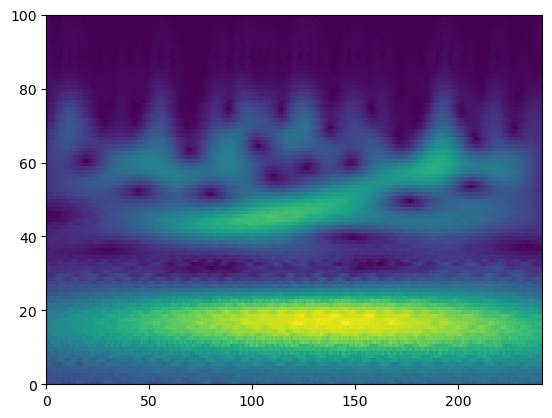

In [ ]:

# data is epoch, channel, time
# we want the transform for each epoch, at each channel, for each time. 
signal = data.data['BCOM_01']['a_12'][0][0]
processed = scalogram_de_reconstruction(signal, wavelet='db4', level=5)
coefficients = scalogram_cwt(processed_data=processed, B=1.0, C=1.0, wavelet='cmor', sampling_rate=300, log_samples=100)
plt.pcolormesh(np.abs(coefficients))

sampling_rate = 300
log_samples = 100
wavelet = 'cmor'
B = 1.0
C = 1.0 

for subject in data.data:
    for syllable in data.data[subject]:
        all_coefficients = np.zeros((data.data[subject][syllable].shape[0], data.data[subject][syllable].shape[1], log_samples, data.data[subject][syllable].shape[2]))
        for epoch in range(data.data[subject][syllable].shape[0]):
            for channel in range(data.data[subject][syllable].shape[1]):
                signal = data.data[subject][syllable][epoch][channel]
                processed = scalogram_de_reconstruction(signal, wavelet='db4', level=5)
                coefficients = scalogram_cwt(processed_data=processed, B=B, C=C, wavelet=wavelet, sampling_rate=sampling_rate, log_samples=log_samples)
                # need one that is 1xchannelxcoefficientsxtime
                all_coefficients[epoch, channel] = np.abs(coefficients)
                break
        np.save(f"{subject}_{syllable}_coefficients.npy", all_coefficients)
        break
    break

